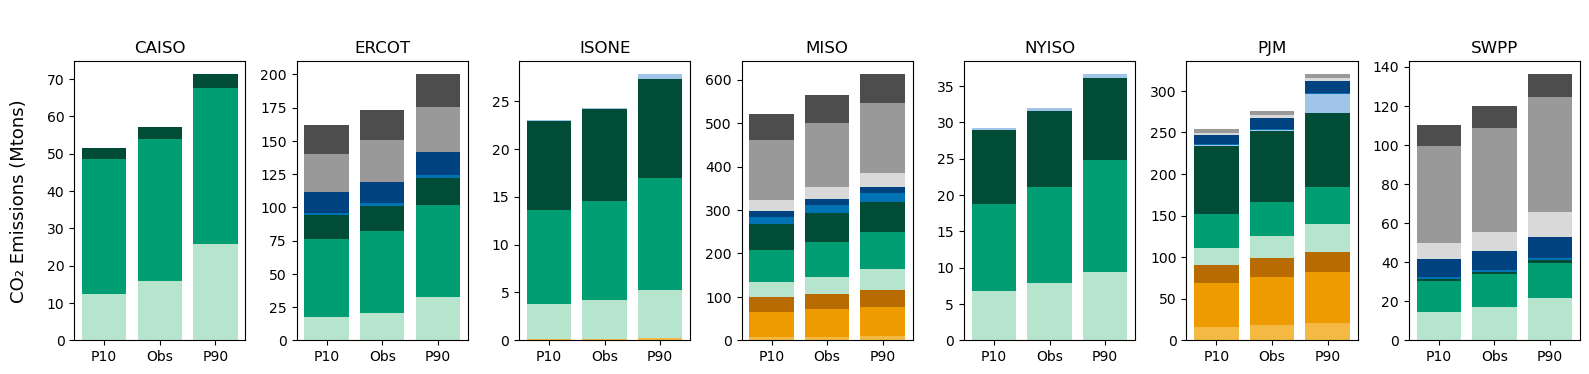

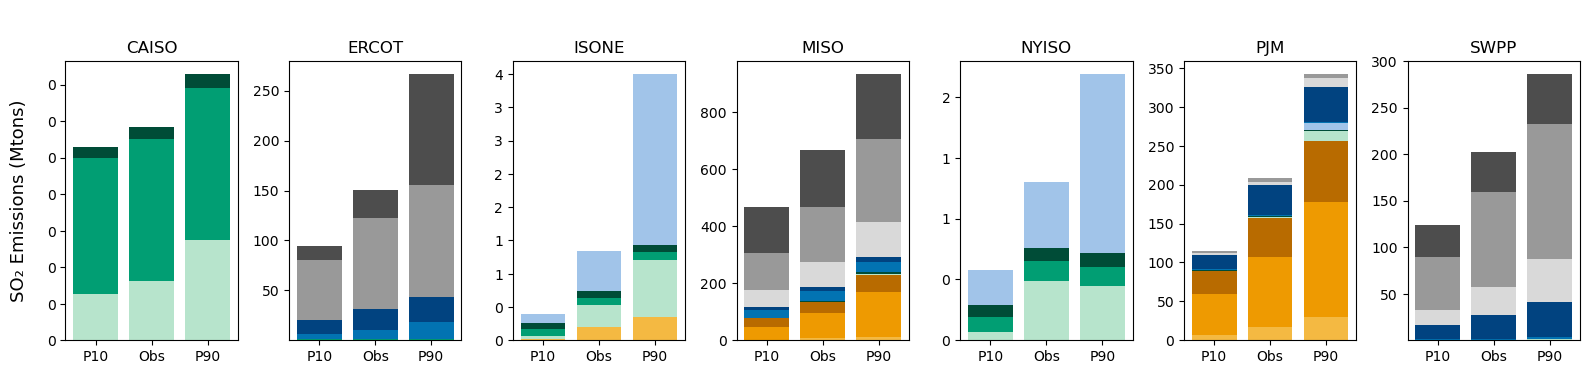

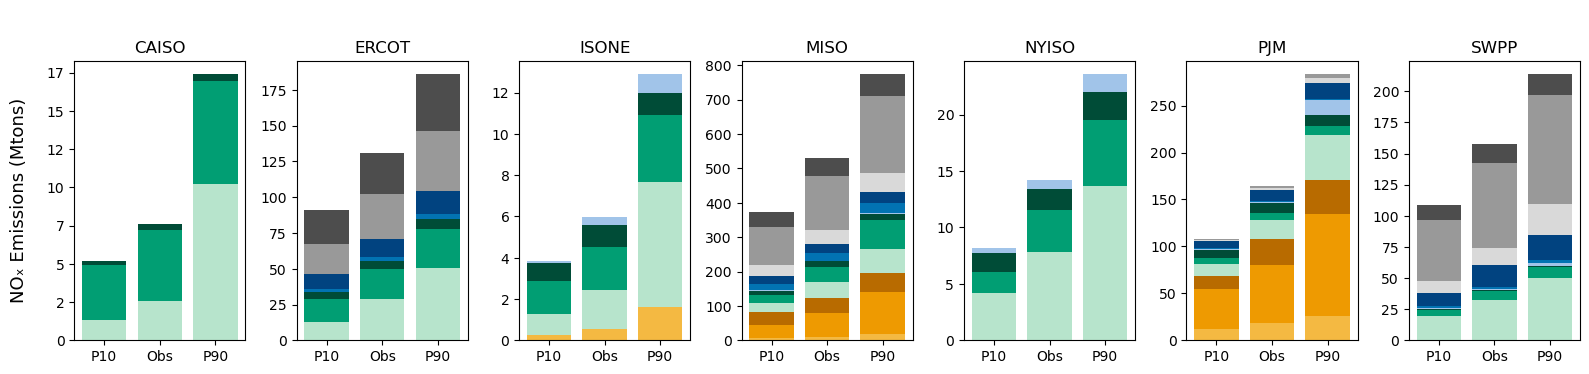

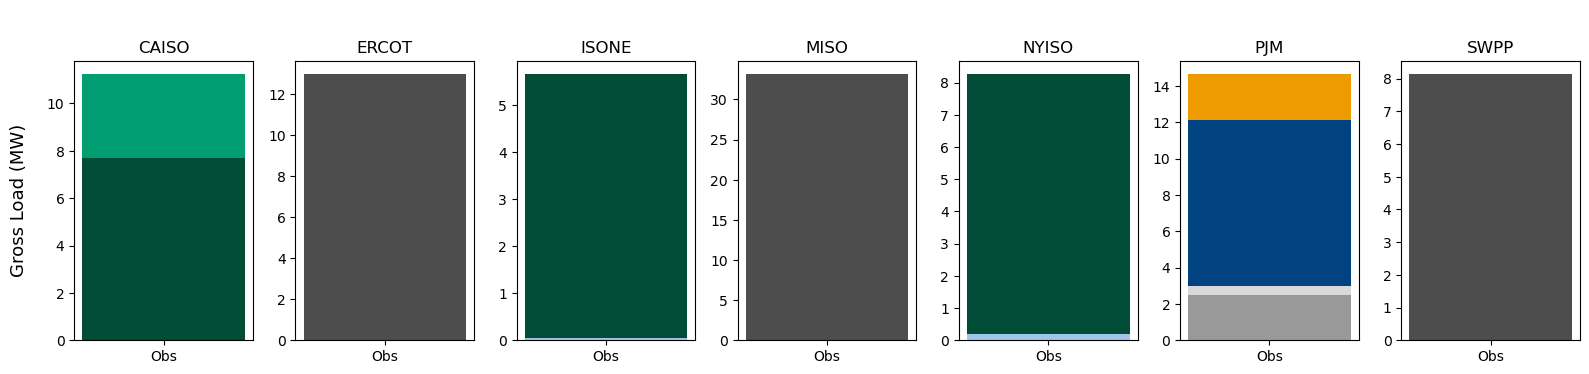

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define categories and color scheme
categories = {
    'BIT_low': '#f4b942', 'BIT_mid': '#ee9a01', 'BIT_high': '#b86b00',
    'SUB_low': '#d9d9d9', 'SUB_mid': '#999999', 'SUB_high': '#4d4d4d',
    'NG_low': '#b7e4cc', 'NG_mid': '#019e73', 'NG_high': '#004c37',
    'Other_low': '#a1c4e9', 'Other_mid': '#0273b2', 'Other_high': '#014380'
}

# Function to process data for each ISO and calculate P10, Observed, and P90 values
def process_iso_data(emissions_data, plant_metadata):
    emissions_data = emissions_data.rename(columns={
        'Gross Load (MW)': 'gross_load_mw',
        'CO2 Mass (short tons)': 'co2_tons',
        'SO2 Mass (lbs)': 'so2_lbs',
        'NOx Mass (lbs)': 'nox_lbs',
        'Heat Input (mmBtu)': 'heat_input_mmbtu'
    })

    # Calculate emission intensities and remove NaNs
    emissions_data["co2_EI"] = emissions_data["co2_tons"] / emissions_data["gross_load_mw"]
    emissions_data["so2_EI"] = emissions_data["so2_lbs"] / emissions_data["gross_load_mw"]
    emissions_data["nox_EI"] = emissions_data["nox_lbs"] / emissions_data["gross_load_mw"]
    emissions_data = emissions_data.dropna().replace([np.inf, -np.inf], np.nan).dropna()

    # Aggregate statistics for each Facility ID
    emissions_data_grouped = emissions_data.groupby('Facility ID').agg(
        mean_co2_EI=('co2_EI', 'mean'),
        p90_co2_EI=('co2_EI', lambda x: np.percentile(x, 90)),
        p10_co2_EI=('co2_EI', lambda x: np.percentile(x, 10)),
        mean_so2_EI=('so2_EI', 'mean'),
        p90_so2_EI=('so2_EI', lambda x: np.percentile(x, 90)),
        p10_so2_EI=('so2_EI', lambda x: np.percentile(x, 10)),
        mean_nox_EI=('nox_EI', 'mean'),
        p90_nox_EI=('nox_EI', lambda x: np.percentile(x, 90)),
        p10_nox_EI=('nox_EI', lambda x: np.percentile(x, 10))
    ).reset_index()

    # Merge with metadata
    emissions_data_grouped = pd.merge(emissions_data_grouped, plant_metadata, on='Facility ID', how='left')

    # Filter for the year 2023 and sum the emissions and load
    emissions_data['datetime'] = pd.to_datetime(emissions_data['datetime'])
    data_2023 = emissions_data[emissions_data.datetime.dt.year == 2023]
    data_2023 = data_2023.groupby('Facility ID')[['co2_tons', 'so2_lbs', 'nox_lbs', 'gross_load_mw']].sum().reset_index()

    # Merge back with aggregated data
    data_2023 = pd.merge(data_2023, emissions_data_grouped, on='Facility ID', how='left')

    # Calculate tons for different EI percentiles
    data_2023['p10_co2_tons'] = data_2023['p10_co2_EI'] * data_2023['gross_load_mw']
    data_2023['p90_co2_tons'] = data_2023['p90_co2_EI'] * data_2023['gross_load_mw']
    data_2023['p10_so2_lbs'] = data_2023['p10_so2_EI'] * data_2023['gross_load_mw']
    data_2023['p90_so2_lbs'] = data_2023['p90_so2_EI'] * data_2023['gross_load_mw']
    data_2023['p10_nox_lbs'] = data_2023['p10_nox_EI'] * data_2023['gross_load_mw']
    data_2023['p90_nox_lbs'] = data_2023['p90_nox_EI'] * data_2023['gross_load_mw']

    # Categorize the fuels
    data_2023['Category'] = data_2023['Primary Fuel'].apply(lambda x: x if x in ['NG', 'SUB', 'BIT'] else 'Other')

    # Group by category and capacity factor, and include gross_load_mw
    return data_2023.groupby(['Category', 'Capacity Factor']).agg({
        'co2_tons': 'sum', 'p10_co2_tons': 'sum', 'p90_co2_tons': 'sum',
        'so2_lbs': 'sum', 'p10_so2_lbs': 'sum', 'p90_so2_lbs': 'sum',
        'nox_lbs': 'sum', 'p10_nox_lbs': 'sum', 'p90_nox_lbs': 'sum',
        'gross_load_mw': 'sum'
    }).reset_index()

# Function to plot each scenario for each pollutant
def plot_scenario(ISO_data, metric, y_label):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16, 4.5), sharey=False)
    metric_map = {
        'CO2': ['p10_co2_tons', 'co2_tons', 'p90_co2_tons'],
        'SO2': ['p10_so2_lbs', 'so2_lbs', 'p90_so2_lbs'],
        'NOx': ['p10_nox_lbs', 'nox_lbs', 'p90_nox_lbs']
    }
    labels = ['P10', 'Obs', 'P90'] if metric in metric_map else ['Obs']

    for i, (iso_name, grouped_data) in enumerate(ISO_data.items()):
        ax = axes[i]
        bottom = [0, 0, 0] if metric in metric_map else [0]
        
        for _, row in grouped_data.iterrows():
            category_key = f"{row['Category']}_low" if row['Capacity Factor'] < 0.3 else \
                           f"{row['Category']}_mid" if row['Capacity Factor'] < 0.6 else \
                           f"{row['Category']}_high"
            
            # Select values based on the metric
            if metric in metric_map:
                values = [row[metric_map[metric][0]], row[metric_map[metric][1]], row[metric_map[metric][2]]]
            else:
                values = [row['gross_load_mw']]
            
            # Plot bars
            bars = ax.bar(labels, values, bottom=bottom[:len(values)], color=categories[category_key], 
                          label=category_key if i == 0 else "")
            
            # Update cumulative bottom for stacking
            if metric in metric_map:
                bottom = [sum(x) for x in zip(bottom, values)]
        
        ax.set_title(iso_name)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)

    # Common y-axis label
    axes[0].set_ylabel(y_label, va='center', rotation='vertical', labelpad=20, fontsize=13)
    
    # Format y-axis to show values in millions (M for emissions, MW for load)
    for ax in axes:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x / 1e6))))

    # Add a legend for the first subplot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(bottom=0.25)
    plt.show()

plant_metadata_CAISO = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - CAISO.csv')
plant_metadata_PJM = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - Sheet1.csv')
plant_metadata_ERCOT = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - ERCOT.csv')
plant_metadata_ISONE = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - ISONE.csv')
plant_metadata_NYISO = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - NYISO.csv')
plant_metadata_MISO = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - MISO.csv')
plant_metadata_SWPP = pd.read_csv('/Users/dhruvsuri/Downloads/PJM_plant_metadata_2 - SWPP.csv')

# Assuming similar datasets are available for all ISOs
ISO_data = {
    'CAISO': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_CAISO.csv'), plant_metadata_CAISO),
    'ERCOT': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_ERCOT.csv'), plant_metadata_ERCOT),
    'ISONE': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_ISONE.csv'), plant_metadata_ISONE),
    'MISO': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_MISO.csv'), plant_metadata_MISO),
    'NYISO': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_NYISO.csv'), plant_metadata_NYISO),
    'PJM': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/raw_states/aggregated_data_filtered.csv'), plant_metadata_PJM),
    'SWPP': process_iso_data(pd.read_csv('/Users/dhruvsuri/Code/PJM_0824/aggregated_data_filtered_SWPP.csv'), plant_metadata_SWPP),
}

# Plot each pollutant with scenarios and Gross Load as observed only
plot_scenario(ISO_data, 'CO2', 'CO₂ Emissions (Mtons)')
plot_scenario(ISO_data, 'SO2', 'SO₂ Emissions (Mtons)')
plot_scenario(ISO_data, 'NOx', 'NOₓ Emissions (Mtons)')
plot_scenario(ISO_data, 'Gross Load', 'Gross Load (MW)')


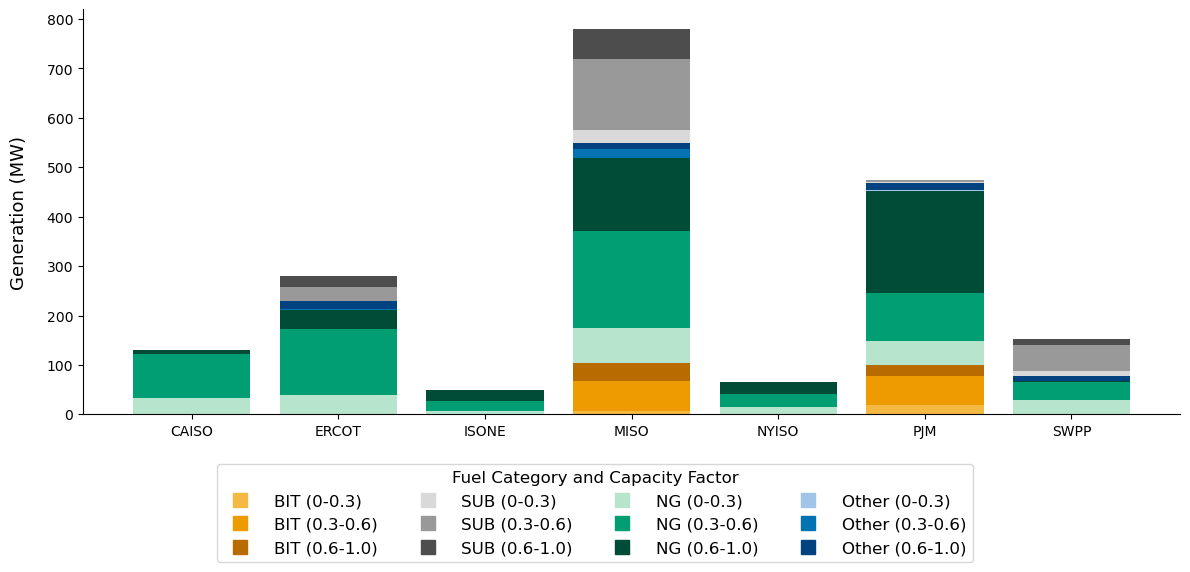

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the color mapping for each category and CF bucket
categories = {
    'BIT_low': '#f4b942', 'BIT_mid': '#ee9a01', 'BIT_high': '#b86b00',
    'SUB_low': '#d9d9d9', 'SUB_mid': '#999999', 'SUB_high': '#4d4d4d',
    'NG_low': '#b7e4cc', 'NG_mid': '#019e73', 'NG_high': '#004c37',
    'Other_low': '#a1c4e9', 'Other_mid': '#0273b2', 'Other_high': '#014380'
}

def plot_generation_by_cf(ISO_data):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(ISO_data))  # Position each ISO on the x-axis

    bottom = np.zeros(len(x))  # Initialize the stacking bottom as zero

    # Iterate over each ISO and plot the stacked segments for each category and CF bucket
    for i, (iso_name, grouped_data) in enumerate(ISO_data.items()):
        # Sum generation for each category and capacity factor bucket within each ISO
        for category in grouped_data['Category'].unique():
            for cf_label, cf_range in [('low', (0, 0.3)), ('mid', (0.3, 0.6)), ('high', (0.6, 1))]:
                # Calculate total generation for this category and capacity factor range
                cf_gen = grouped_data[
                    (grouped_data['Category'] == category) & 
                    (grouped_data['Capacity Factor'].between(cf_range[0], cf_range[1]))
                ]['gross_load_mw'].sum()

                # Skip if there is no generation for this category and CF range
                if cf_gen == 0:
                    continue

                # Determine color for the category and CF range
                color_key = f"{category}_{cf_label}"
                color = categories.get(color_key, '#000000')  # Default to black if not found in categories

                # Plot the stacked segment for this category and CF bucket
                ax.bar(x[i], cf_gen, bottom=bottom[i], color=color)
                
                # Update the bottom to stack the next segment on top
                bottom[i] += cf_gen

    # Set the x-axis labels for each ISO
    ax.set_xticks(x)
    ax.set_xticklabels(ISO_data.keys(), rotation=0)
    
    # Add y-axis label
    ax.set_ylabel('Generation (MW)', va='center', rotation='vertical', labelpad=20, fontsize=13)
    
    # Format y-axis to show values in millions (MW)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x / 1e6))))
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create custom legend
    legend_entries = [
        ('BIT (0-0.3)', categories['BIT_low']),
        ('BIT (0.3-0.6)', categories['BIT_mid']),
        ('BIT (0.6-1.0)', categories['BIT_high']),
        ('SUB (0-0.3)', categories['SUB_low']),
        ('SUB (0.3-0.6)', categories['SUB_mid']),
        ('SUB (0.6-1.0)', categories['SUB_high']),
        ('NG (0-0.3)', categories['NG_low']),
        ('NG (0.3-0.6)', categories['NG_mid']),
        ('NG (0.6-1.0)', categories['NG_high']),
        ('Other (0-0.3)', categories['Other_low']),
        ('Other (0.3-0.6)', categories['Other_mid']),
        ('Other (0.6-1.0)', categories['Other_high'])
    ]
    handles = [plt.Line2D([0], [0], marker='s', color=color, linestyle='', markersize=10) for _, color in legend_entries]
    labels = [label for label, _ in legend_entries]
    
    fig.legend(handles, labels, loc='lower center', title='Fuel Category and Capacity Factor',
               ncol=4, frameon=True, handletextpad=1, columnspacing=2, bbox_to_anchor=(0.5, -0.01), fontsize=12,
               title_fontsize=12)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# Now call the function to plot generation by capacity factor for all BAs
plot_generation_by_cf(ISO_data)


In [29]:
df_gen_path = '../data/processed/ERCO.csv'
df_gen = pd.read_csv(df_gen_path)
columns = ['Local time', 'NG: SUN', 'NG: WND', 'D','NG: COL', 'NG: NG', 'NG: OIL', 'NG: WAT', 'TI', 'solar_ext_mw', 'wind_ext_mw', 'demand_ext_mw']
df_gen = df_gen[columns]

# Convert 'Local time' to datetime
df_gen['Local time'] = pd.to_datetime(df_gen['Local time'])

# Filter for the year 2023
data_2023 = df_gen[df_gen['Local time'].dt.year == 2023]

# Calculate the sum of 'NG: SUN' and 'NG: WND'
sum_ng_sun = data_2023['NG: SUN'].sum()
sum_ng_wnd = data_2023['NG: WND'].sum()

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_generation_by_cf(ISO_data):
    fig, ax = plt.subplots(figsize=(11, 4.5))
    x = np.arange(len(ISO_data))
    bottom = np.zeros(len(x))

    # Plot stacked bars for thermal generation
    for i, (iso_name, grouped_data) in enumerate(ISO_data.items()):
        iso_bottom = 0
        
        for category in grouped_data['Category'].unique():
            for cf_label, cf_range in [('low', (0, 0.3)), ('mid', (0.3, 0.6)), ('high', (0.6, 1))]:
                cf_gen = grouped_data[
                    (grouped_data['Category'] == category) & 
                    (grouped_data['Capacity Factor'].between(cf_range[0], cf_range[1]))
                ]['gross_load_mw'].sum()

                if cf_gen == 0:
                    continue

                color_key = f"{category}_{cf_label}"
                color = categories.get(color_key, '#000000')

                ax.bar(x[i], cf_gen, bottom=iso_bottom, color=color)
                iso_bottom += cf_gen

    # Plot solar and wind points
    for i, iso_name in enumerate(ISO_data.keys()):
        solar_gen, wind_gen = load_solar_wind_data(iso_name)
        
        # Convert to same units as the stacked bars (MW)
        solar_gen = solar_gen * 1e6
        wind_gen = wind_gen * 1e6
        
        # Plot points with updated styles
        ax.plot(x[i], solar_gen, 'o', color='orange', markersize=10, markeredgecolor='black', markeredgewidth=1, label='Solar' if i == 0 else "")
        ax.plot(x[i], wind_gen, 'o', color='blue', markersize=10,markeredgecolor='black', markeredgewidth=1, label='Wind' if i == 0 else "")

    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(ISO_data.keys(), rotation=0)
    ax.set_ylabel('Generation (TWh)', va='center', rotation='vertical', labelpad=20, fontsize=13)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x / 1e6))))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create all legend entries
    legend_entries = [
        ('BIT (0-0.3)', categories['BIT_low'], 's'),
        ('BIT (0.3-0.6)', categories['BIT_mid'], 's'),
        ('BIT (0.6-1.0)', categories['BIT_high'], 's'),
        ('SUB (0-0.3)', categories['SUB_low'], 's'),
        ('SUB (0.3-0.6)', categories['SUB_mid'], 's'),
        ('SUB (0.6-1.0)', categories['SUB_high'], 's'),
        ('NG (0-0.3)', categories['NG_low'], 's'),
        ('NG (0.3-0.6)', categories['NG_mid'], 's'),
        ('NG (0.6-1.0)', categories['NG_high'], 's'),
        ('Other (0-0.3)', categories['Other_low'], 's'),
        ('Other (0.3-0.6)', categories['Other_mid'], 's'),
        ('Other (0.6-1.0)', categories['Other_high'], 's'),
        ('Solar generation', 'orange', 'o'),  # Add solar and wind to legend entries
        ('Wind generation', 'blue', 'o')
    ]

    # Create handles and labels
    handles = []
    for label, color, marker in legend_entries:
        if marker == 's':
            handle = plt.Line2D([0], [0], marker=marker, color=color, linestyle='', markersize=10)
        elif label == 'Solar generation':
            handle = plt.Line2D([0], [0], marker=marker, color=color, markeredgecolor='black', 
                               markeredgewidth=1, linestyle='none', markersize=10)
        else:  # Wind generation
            handle = plt.Line2D([0], [0], marker=marker, color=color, markeredgecolor='black', 
                               markeredgewidth=1, linestyle='none', markersize=10)
        handles.append(handle)
    
    labels = [entry[0] for entry in legend_entries]

    # Place legend with 5 columns (4 for fuel categories, 1 for renewables)
    fig.legend(handles, labels, loc='lower center', title='Fuel Category and Capacity Factor',
              ncol=5, frameon=True, handletextpad=1, columnspacing=2, 
              bbox_to_anchor=(0.5, -0.1), fontsize=12, title_fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.subplots_adjust(bottom=0.25)
    plt.show()

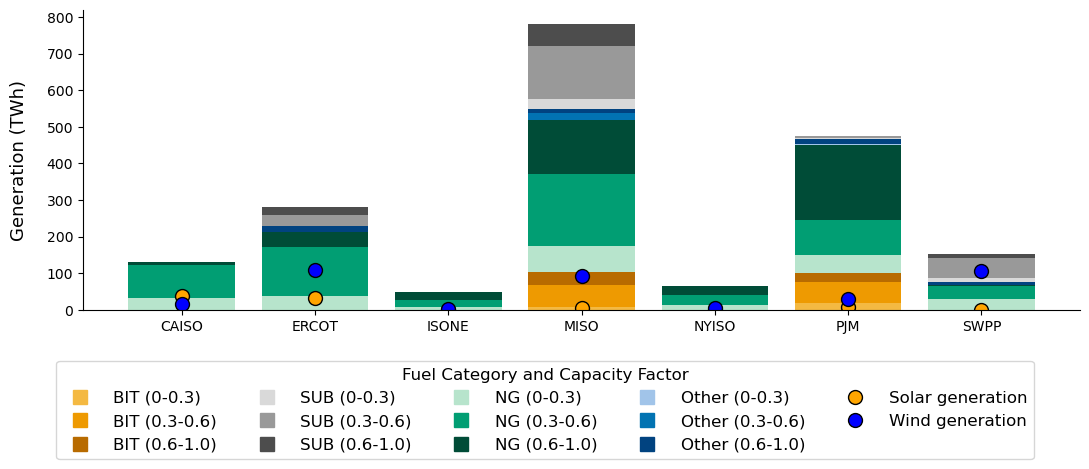

In [32]:
plot_generation_by_cf(ISO_data)